**Sentiment Analysis of IMDB Movie Reviews**

IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.
For more dataset information, please go through the following link,
http://ai.stanford.edu/~amaas/data/sentiment/



**Homework Assignment**

* Load the IMDB review data set. Perform stemming and remove the non-alphabets and stop words.

* Create the **TD matrix** for both the training and testing data.

* Create the **TF-IDF matrix** for both the training and testing data.

* Let $n$ and $p$ stand for the number of observations and the number of features, respectively. Print $n$ and $p$.

* Fit a logistic regression model (with no regularization) to the training **TD matrix**. Call the resulting model **TD-logistic-model**.

* Fit a logistic regression model (with no regularization) to the training **TF-IDF matrix**. Call the resulting model **TF-IDF-logistic-model**.


* Use the **TD-logistic-model** to make predictions, and to compute the true and false positive rate for the testing data for thresholds $\theta \in [0.01, 0.02, 0.03, \cdots, 0.96, 0.97, 0.98, 0.99]$.


* Use the **TF-IDF-logistic-model** to make predictions, and to compute the true and false positive rate for the testing data for thresholds $\theta \in [0.01, 0.02, 0.03, \cdots, 0.96, 0.97, 0.98, 0.99]$.

* Use the last two parts, to compute the test AUC for **TD-logistic-model** and **TF-IDF-logistic-model**, and to plot the ROC for both models on the same plot, and to report the AUCs on the plot.

* Do you see a difference between the test AUC performance for the two models?



In [ ]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import re

seed = 1

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

* Load the IMDB review data set. Perform stemming and remove the non-alphabets and stop words.


In [ ]:
# Download and Load IMDb dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8IBS1P/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8IBS1P/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8IBS1P/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess(text):
    text = text.decode('utf-8')  # Decode bytes to string
    words = text.lower().split()
    # remove stop words and non-alpha
    words = ' '.join([stemmer.stem(word) for word in words if word not in stop_words and word.isalpha()])
    return words

In [ ]:
# Extract X and y from train and test datasets
X_train = [preprocess(text.numpy()) for text, _ in train_dataset]
y_train = [label.numpy() for _, label in train_dataset]
X_test = [preprocess(text.numpy()) for text, _ in test_dataset]
y_test = [label.numpy() for _, label in test_dataset]

* Create the **TD matrix** for both the training and testing data.

In [ ]:
# Vectorization of text data
td_vectorizer = CountVectorizer()
X_train_td = td_vectorizer.fit_transform(X_train)
X_test_td = td_vectorizer.transform(X_test)

* Create the **TF-IDF matrix** for both the training and testing data.

In [ ]:
# Vectorization of text data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

* Let $n$ and $p$ stand for the number of observations and the number of features, respectively. Print $n$ and $p$.

In [ ]:
print(f'n: {X_train_tfidf.shape[0]}')
print(f'p: {X_test_tfidf.shape[1]}')

n: 25000
p: 40389


**Do the above for $C=0.001, C=0.1, C=10$ and create two ROC plots, one for train, the other for text data**

In other words, the train figure whould be the ROC for the thr Cs, and the two models (TD and TF-IDF), leading to six ROC's on the same graph with appropiate labeling. Do the same thing for the test data.

Also, make a $2 \times 6$ table that reports the train and test error for each of the 6 models. Note: compute the the train and test error for the typical threshold of $\theta=0.5$.

In [ ]:
C_values = [0.001, 0.1, 10]
roc_data = {}
columns = [(f"C={C}", model_type) for C in C_values for model_type in ['TD', 'TF-IDF']]
error_df = pd.DataFrame(columns=columns, index=['Train', 'Test'])

for C in C_values:
    for model_type, X_train, X_test in [('TD', X_train_td, X_test_td), ('TF-IDF', X_train_tfidf, X_test_tfidf)]:
        # Fit and predict
        model = LogisticRegression(C=C, max_iter=1000, random_state=seed)
        model.fit(X_train, y_train)
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]

        # TPR and FPR
        thresholds = np.arange(0.01, 1, 0.01)
        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob, pos_label=1)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob, pos_label=1)

        # Compute AUC
        auc_train = roc_auc_score(y_train, y_train_prob)
        auc_test = roc_auc_score(y_test, y_test_prob)

        # ROC data
        roc_data[(C, model_type, 'Train')] = (fpr_train, tpr_train, auc_train)
        roc_data[(C, model_type, 'Test')] = (fpr_test, tpr_test, auc_test)

        # Compute predictions for theta = 0.5
        y_train_pred = [1 if prob > 0.5 else 0 for prob in y_train_prob]
        y_test_pred = [1 if prob > 0.5 else 0 for prob in y_test_prob]

        # Compute errors
        train_error = np.mean(y_train_pred != np.array(y_train))
        test_error = np.mean(y_test_pred != np.array(y_test))

        # Store errors in the DataFrame
        error_df.at['Train', (f"C={C}", model_type)] = round(train_error, 2)
        error_df.at['Test', (f"C={C}", model_type)] = round(test_error, 2)

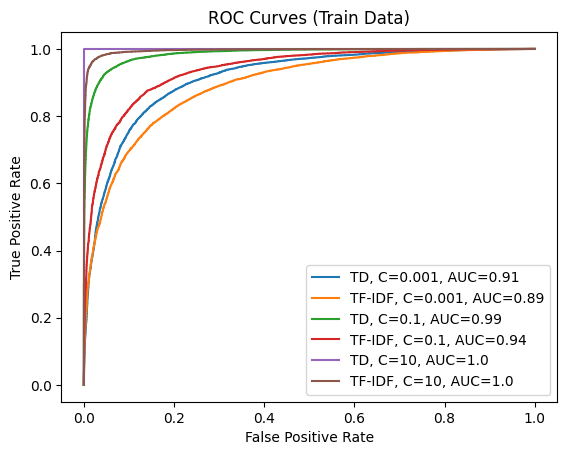

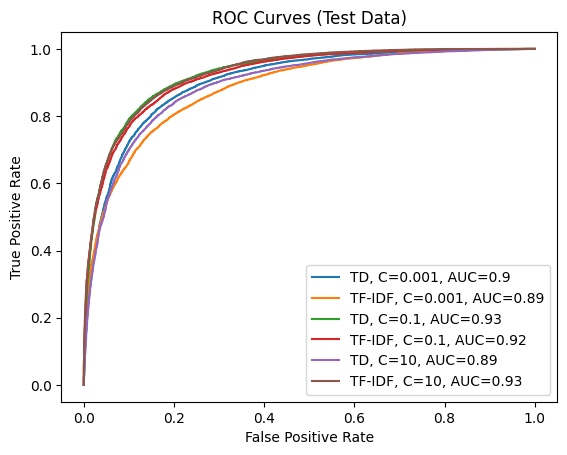

In [ ]:
# ROC Plots
for data_type in ['Train', 'Test']:
    for C in C_values:
        for model_type in ['TD', 'TF-IDF']:
            fpr, tpr, auc = roc_data[(C, model_type, data_type)]
            plt.plot(fpr, tpr, label=f"{model_type}, C={C}, AUC={round(auc, 2)}")
    plt.title(f"ROC Curves ({data_type} Data)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

In [45]:
# Error table
error_df

,"(C=0.001, TD)","(C=0.001, TF-IDF)","(C=0.1, TD)","(C=0.1, TF-IDF)","(C=10, TD)","(C=10, TF-IDF)"
Train,0.16,0.19,0.06,0.14,0.0,0.03
Test,0.17,0.2,0.15,0.16,0.18,0.15


* Do you see a difference between the test AUC performance for the two models?

Yes.  
* For training data, TD is always better than TF-IDF under different C values.
* For testing data, TFIDF is better than TD when regularization is strong.